<h1>Phi K Correlation</h1>

Phi K correlation is a newly emerging correlation cofficient with following advantages:

- it can work consistently between categorical, ordinal and interval variables
- it can capture non-linear dependency
- it reverts to the Pearson correlation coefficient in case of a bi-variate normal input distribution

In [19]:
import phik

from phik import resources
from phik.binning import bin_data
from phik.decorators import *
from phik.report import plot_correlation_matrix


import pandas as pd  
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [8]:
#loading the SalePrice dataset
df=pd.read_csv('dataset.csv')
df.drop(['Id'], axis=1,inplace=True)

**Preprocessing**

In [9]:
#Preprocessing the data
class PreProcessor:
    def __init__(self):
        #treating certain categorical columns as ordinal
        self.encoder={}
        self.encoder['LotShape']={'Reg':0,'IR1':1,'IR2':2,'IR3':3}
        self.encoder['LandSlope']={'Gtl':1, 'Mod':2, 'Sev':3}
        self.encoder['GarageFinish']={'Fin':3, 'RFn':2, 'Unf':1, 'VNA':0}
        self.encoder['BsmtExposure']={'Gd':4,'Av':3,'Mn':2,'No':1,'VNA':0}
        self.encoder['Functional']={'Typ':0,'Min1':1,'Min2':2,'Mod':3,'Maj1':4,'Maj2':5,'Sev':6,'Sal':7}
        self.encoder['PavedDrive']={'Y':2,'P':1,'N':0}
        #columns with values as Ex,Gd,TA,Fa,Po,VNA can be treated as ordinal
        ratings={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'VNA':0}
        rated_cols=['ExterQual', 'ExterCond','BsmtQual','BsmtCond','KitchenQual','FireplaceQu','GarageQual', 'GarageCond']
        for col in rated_cols:
            self.encoder[col]=ratings
        self.categorical_encoded=self.encoder.keys()
        
        
        
    def preprocessing1(self,df):
        #drop columns with mostly one value or mostly missing values
        dropped_cols=['Street', 'Alley', 'Utilities', 'Condition2', 'RoofMatl', 'Heating','LowQualFinSF', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']
        df.drop(dropped_cols, axis=1, inplace=True)
        
        #treating missing values
        #Filling missing values with median
        col1=['LotFrontage','MasVnrArea']
        for col in col1:
            df[col].fillna(df[col].median(), inplace=True)
        #Fill missing values with new category "VNA"
        col2=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','GarageCond','FireplaceQu','MasVnrType',  'Electrical']
        for col in col2:
            df[col].fillna('VNA', inplace=True)
            
        #Replacing Na values in GarageYrBlt with corresponding values in YearBuilt
        df.loc[(pd.isnull(df.GarageYrBlt)), 'GarageYrBlt'] = df.YearBuilt
            
        #encoding categorical columns to ordinal 
        for col in self.categorical_encoded:
            df[col]=df[col].apply(lambda val: self.encoder[col][val])
            
        #apply lable encoder
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = LabelEncoder().fit_transform(df[col])
            
        return df
    
    def preprocessing2(self,df):
        df=self.preprocessing1(df)
        
        #filtered columns
        numerical_filtered=['YearBuilt','TotRmsAbvGrd','GrLivArea','1stFlrSF','GarageYrBlt','YearRemodAdd','GarageArea','SalePrice']
        ordinal_filtered=['GarageCars','OverallQual','Fireplaces','GarageFinish','BsmtFullBath','KitchenQual','FullBath','FireplaceQu','BsmtQual','TotalBsmtSF']
        categorical_filtered=['MSZoning', 'Neighborhood', 'Foundation', 'BsmtFinType1', 'HeatingQC', 'CentralAir', 'GarageType', 'SaleCondition', 'MSSubClass', 'MasVnrType']
        
        return df[numerical_filtered+ordinal_filtered+categorical_filtered], numerical_filtered
        
            

In [10]:
#create pre processor object
pre_processor=PreProcessor()

#preprocess the data and get interval column
preprocessed_df, interval_cols=pre_processor.preprocessing2(df)

**PhiK correlation**

<function matplotlib.pyplot.show(close=None, block=None)>

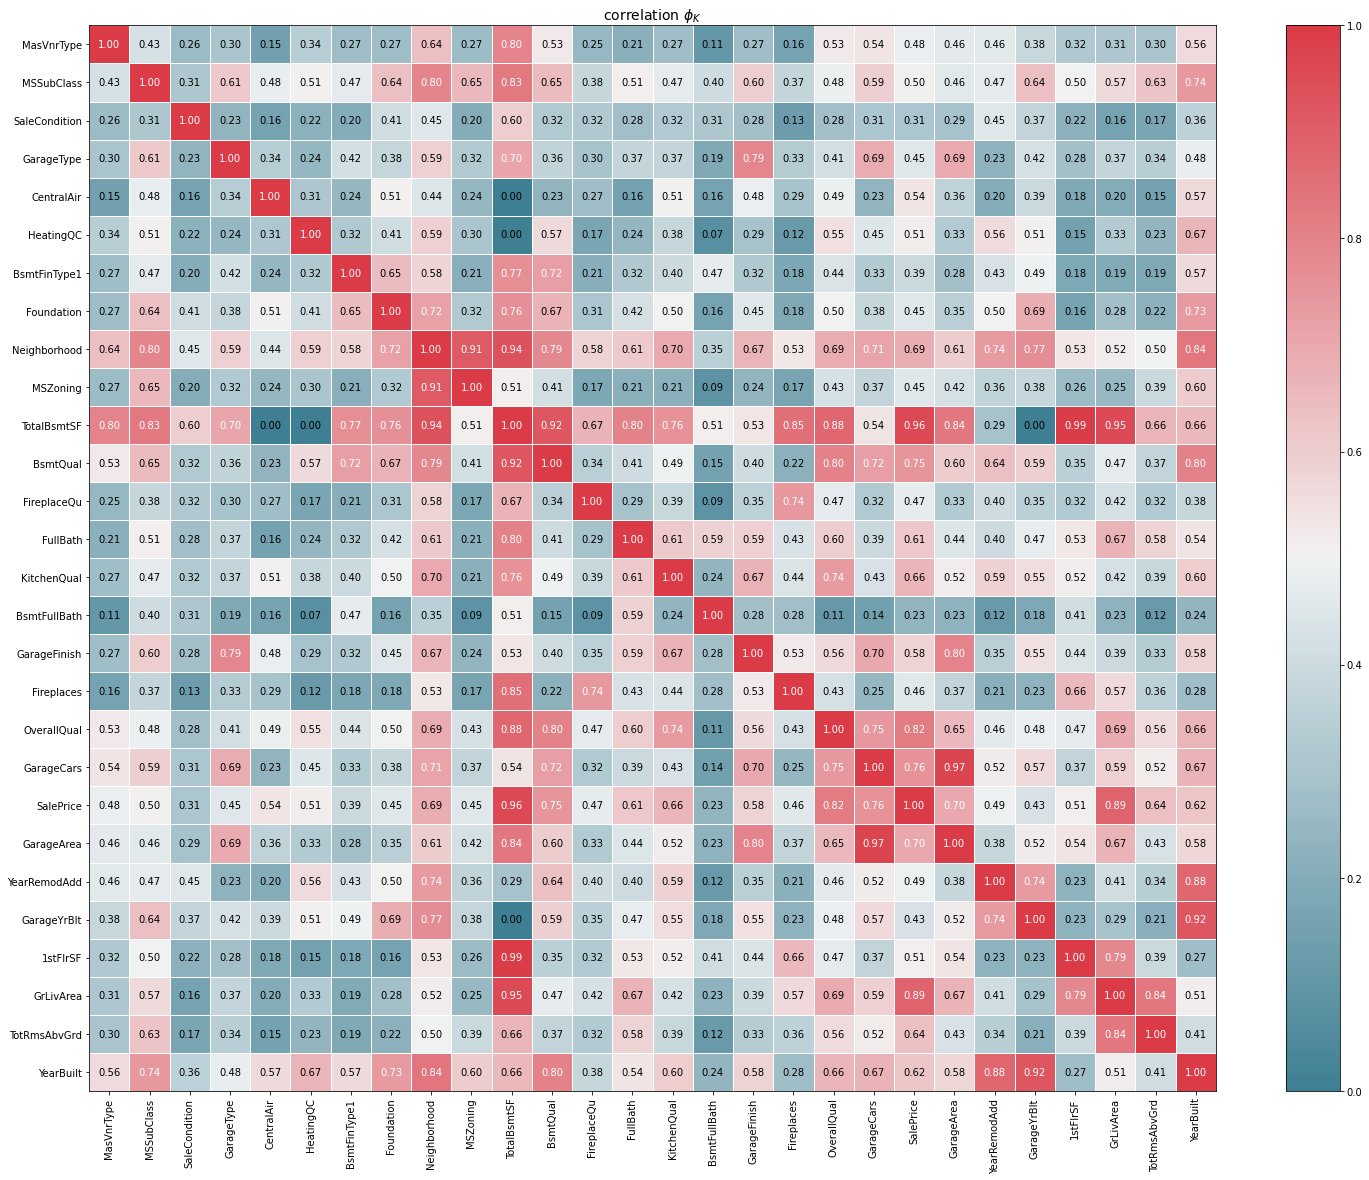

In [16]:
# get the phi_k correlation matrix between all variables
coerr_mat=preprocessed_df.phik_matrix(interval_cols=interval_cols)

#colour map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#plotting phik correlation
plot_correlation_matrix(coerr_mat.values, x_labels=coerr_mat.columns, y_labels=coerr_mat.index, 
                        vmin=0, vmax=1, color_map=cmap, title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(7*3,5.5*3))
plt.tight_layout()
plt.show

**Finding highly correlated features based on above heat map and vizualizing it as a graph**

In [34]:
class GraphVisualization:
   
    def __init__(self):
          
        # visual is a list which stores all 
        # the set of edges that constitutes a
        # graph
        self.visual = []
          
    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_shell(G, alpha = 0.7, with_labels = True, edge_color ='.4', cmap = cmap, font_size=12 )
        plt.title("correlation vizualization as graph")
        plt.style.use('ggplot')
        plt.figure(figsize=(8,5))
        plt.show()

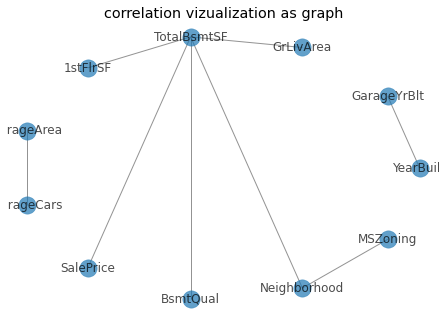

<Figure size 576x360 with 0 Axes>

In [35]:
G = GraphVisualization()
for col1 in preprocessed_df.columns:
    for col2 in preprocessed_df.columns:
        if col1!=col2:
            #if the correlation is greater than 0.9, add an edge to the graph
            if coerr_mat[col1][col2]>0.9:
                G.addEdge(col1,col2) 



G.visualize()

Based on graph plot using PhiK correlation ,following features are highly correlated:
- GarageArea and GarageCars
- GarageTrBlt and YearBuilt
- Neighborhood and MSZoning
- TotalBsmtSF is highly correlated with 1stFlrSF, SalePrice, BsmtQual, GrLivArea and Neighborhood


**Global PhiK Correlations**  
This metric signifies how much a column is correlated with all other columns in the dataset 

C:\Users\Aparna Sakshi\AppData\Roaming\Python\Python37\site-packages\phik\phik.py:250: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


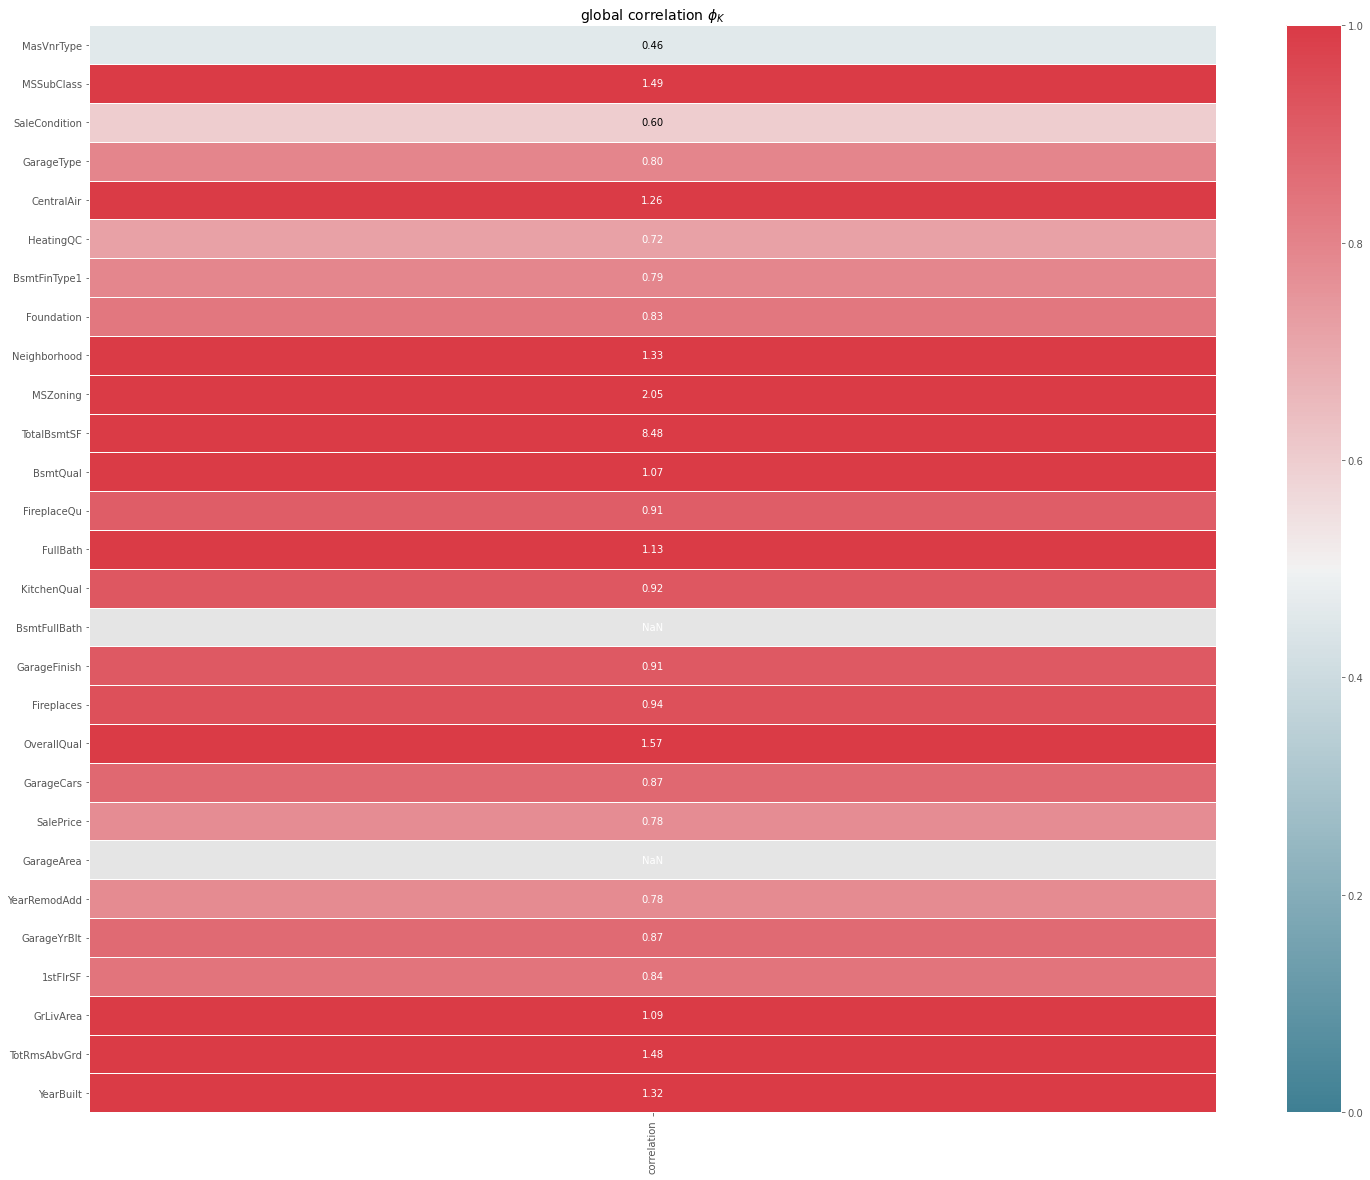

In [64]:
# get global correlations based on phi_k correlation matrix
global_coerr=preprocessed_df.global_phik(interval_cols=interval_cols)


#plotting global phik correlation
plot_correlation_matrix(global_coerr[0], x_labels=["correlation"], y_labels=global_coerr[1],vmin=0, vmax=1, color_map=cmap, title=r'global correlation $\phi_K$', fontsize_factor=1,figsize=(7*3,5.5*3))